This was investigation on how to use train model and check specific dimensions
at all stages

In [1]:
#imports

import os
import numpy as np
from PIL import Image
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision.transforms import ToPILImage
import cv2

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor()
])

In [2]:
# getting exact shape and type of what goes as input to train a model
input_dir = 'C://SelfDrive//2025 Map from vision//img//'
input_images = os.listdir(input_dir)
input_image = Image.open(input_dir+input_images[0]).convert("RGB")
input_image = transform(input_image)

In [3]:
print('shape',input_image.shape)
print('type',type(input_image))



shape torch.Size([3, 480, 640])
type <class 'torch.Tensor'>


In [13]:
input_image

tensor([[[0.4510, 0.4510, 0.4510,  ..., 0.4667, 0.4627, 0.4627],
         [0.4588, 0.4510, 0.4588,  ..., 0.4667, 0.4667, 0.4627],
         [0.4588, 0.4588, 0.4588,  ..., 0.4667, 0.4667, 0.4627],
         ...,
         [0.3176, 0.3176, 0.3098,  ..., 0.2314, 0.2392, 0.2196],
         [0.3020, 0.3098, 0.3098,  ..., 0.2392, 0.2510, 0.2392],
         [0.2941, 0.3020, 0.3176,  ..., 0.2784, 0.2510, 0.2196]],

        [[0.4588, 0.4510, 0.4588,  ..., 0.4667, 0.4667, 0.4627],
         [0.4588, 0.4588, 0.4588,  ..., 0.4667, 0.4667, 0.4627],
         [0.4588, 0.4588, 0.4588,  ..., 0.4667, 0.4667, 0.4627],
         ...,
         [0.2941, 0.2941, 0.2941,  ..., 0.2078, 0.2078, 0.2078],
         [0.2863, 0.2941, 0.2941,  ..., 0.1961, 0.2078, 0.2078],
         [0.2784, 0.2863, 0.2941,  ..., 0.2196, 0.1961, 0.1490]],

        [[0.4706, 0.4706, 0.4745,  ..., 0.4784, 0.4784, 0.4784],
         [0.4745, 0.4706, 0.4745,  ..., 0.4784, 0.4784, 0.4784],
         [0.4706, 0.4745, 0.4745,  ..., 0.4784, 0.4863, 0.

In [11]:

m3_video = cv2.VideoCapture('G:/My Drive/Self-driving/real tesla footage.mp4')
ret, frame = m3_video.read()

In [53]:
frame.shape

(960, 1280, 3)

In [15]:
input_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
input_frame = Image.fromarray(input_frame)
input_frame = transform(input_frame)
input_frame.shape

torch.Size([3, 480, 640])

In [55]:
input_frame = input_frame.unsqueeze(0)
input_frame.shape

torch.Size([1, 3, 480, 640])

Now we have the same shapes of input GRGB and vide frames :)




In [56]:
# now load model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        self.bottleneck = self.conv_block(512, 1024)
        
        self.dec4 = self.conv_block(1024, 512)
        self.dec3 = self.conv_block(512, 256)
        self.dec2 = self.conv_block(256, 128)
        self.dec1 = self.conv_block(128, 64)
        
        self.final = nn.Conv2d(64, 3, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        print("Input:", x.shape) 
        enc1 = self.enc1(x)
        print("Enc1:", enc1.shape)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        print("Enc2:", enc2.shape)
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        print("Enc3:", enc3.shape)
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        print("Enc4:", enc4.shape)
        
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        print("Bottleneck:", bottleneck.shape) 

        dec4 = self.dec4(F.interpolate(bottleneck, scale_factor=2))
        print("Dec4:", dec4.shape) 
        dec3 = self.dec3(F.interpolate(dec4, scale_factor=2))
        print("Dec3:", dec3.shape)
        dec2 = self.dec2(F.interpolate(dec3, scale_factor=2))
        print("Dec2:", dec2.shape)
        dec1 = self.dec1(F.interpolate(dec2, scale_factor=2))
        print("Dec1:", dec1.shape)
        final_output = self.final(dec1)
        print("Final Output:", final_output.shape)
        return final_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device',device)
model = UNet().to(device) 

#load a trained model
state_dict = torch.load('C://SelfDrive//2025 Map from vision//unet_model_20250224_1.pth')  
model.load_state_dict(state_dict)

using device cuda


C:\Users\shumi\AppData\Local\Temp\ipykernel_20080\3724353523.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('C://SelfDrive//2025 Map from visio

<All keys matched successfully>

In [34]:
for key in state_dict.keys():
    print(key, state_dict[key].shape)

enc1.0.weight torch.Size([64, 3, 3, 3])
enc1.0.bias torch.Size([64])
enc1.2.weight torch.Size([64, 64, 3, 3])
enc1.2.bias torch.Size([64])
enc2.0.weight torch.Size([128, 64, 3, 3])
enc2.0.bias torch.Size([128])
enc2.2.weight torch.Size([128, 128, 3, 3])
enc2.2.bias torch.Size([128])
enc3.0.weight torch.Size([256, 128, 3, 3])
enc3.0.bias torch.Size([256])
enc3.2.weight torch.Size([256, 256, 3, 3])
enc3.2.bias torch.Size([256])
enc4.0.weight torch.Size([512, 256, 3, 3])
enc4.0.bias torch.Size([512])
enc4.2.weight torch.Size([512, 512, 3, 3])
enc4.2.bias torch.Size([512])
bottleneck.0.weight torch.Size([1024, 512, 3, 3])
bottleneck.0.bias torch.Size([1024])
bottleneck.2.weight torch.Size([1024, 1024, 3, 3])
bottleneck.2.bias torch.Size([1024])
dec4.0.weight torch.Size([512, 1024, 3, 3])
dec4.0.bias torch.Size([512])
dec4.2.weight torch.Size([512, 512, 3, 3])
dec4.2.bias torch.Size([512])
dec3.0.weight torch.Size([256, 512, 3, 3])
dec3.0.bias torch.Size([256])
dec3.2.weight torch.Size([256

In [57]:
with torch.no_grad():  # Disable gradient computation for inference
    predicted = model(input_frame.to(device)) 


Input: torch.Size([1, 3, 480, 640])
Enc1: torch.Size([1, 64, 480, 640])
Enc2: torch.Size([1, 128, 240, 320])
Enc3: torch.Size([1, 256, 120, 160])
Enc4: torch.Size([1, 512, 60, 80])
Bottleneck: torch.Size([1, 1024, 30, 40])
Dec4: torch.Size([1, 512, 60, 80])
Dec3: torch.Size([1, 256, 120, 160])
Dec2: torch.Size([1, 128, 240, 320])
Dec1: torch.Size([1, 64, 480, 640])
Final Output: torch.Size([1, 3, 480, 640])


In [60]:
# unexpected problem - predicted image in in shape torch.Size([3, 30, 640]) but should be torch.Size([3, 480, 640])
# need to find out why
predicted = predicted.squeeze(0)
predicted.shape

torch.Size([3, 480, 640])

In [36]:
input_frame.shape

torch.Size([3, 480, 640])

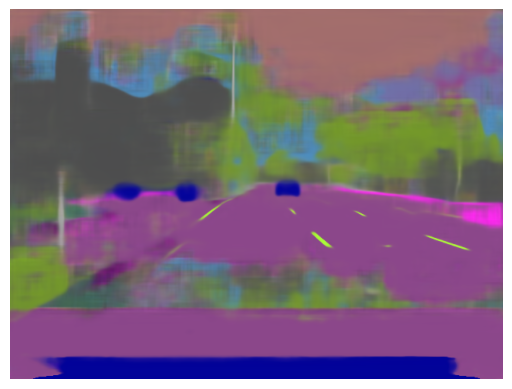

In [61]:
import matplotlib.pyplot as plt

# Convert to numpy and reshape to (H, W, C)
image_np = predicted.permute(1, 2, 0).cpu().detach().numpy()  # Shape (30, 640, 3)

# Normalize if values are not in [0, 1]
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Display the image
plt.imshow(image_np)
plt.axis("off")  # Hide axes
plt.show()